In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [27]:
for mock_no in range(1,21):
    jackknife_file = '/mnt/store1/oliverphilcox/DR12_QPM/xi_jack/mock_%d/xi_jack_n35_m10_j169_11.dat'%mock_no
    weight_dir = '/mnt/store1/oliverphilcox/DR12_QPM/'
    file_root = '/mnt/store1/oliverphilcox/DR12_QPM/output/mock_%d/'%mock_no
    m = 10
    n_samples = 20

    # Load jackknife xi estimates from data
    print("Loading correlation function jackknife estimates from %s"%jackknife_file)
    xi_jack = np.loadtxt(jackknife_file,skiprows=2)
    n_bins = xi_jack.shape[1] # total bins
    n_jack = xi_jack.shape[0] # total jackknives
    n = n_bins//m # radial bins

    weight_file = weight_dir+'jackknife_weights_n%d_m%d_j%d_11.dat'%(n,m,n_jack)
    RR_file = weight_dir+'binned_pair_counts_n%d_m%d_j%d_11.dat'%(n,m,n_jack)

    print("Loading weights file from %s"%weight_file)
    weights = np.loadtxt(weight_file)[:,1:]

    # First exclude any dodgy jackknife regions
    good_jk=np.unique(np.where(np.isfinite(xi_jack))[0])
    print("Using %d out of %d jackknives"%(len(good_jk),n_jack))
    xi_jack = xi_jack[good_jk]
    weights = weights[good_jk]

    # Compute data covariance matrix
    print("Computing data covariance matrix")
    mean_xi = np.sum(xi_jack*weights,axis=0)/np.sum(weights,axis=0)
    tmp = weights*(xi_jack-mean_xi)
    data_cov = np.matmul(tmp.T,tmp)
    denom = np.matmul(weights.T,weights)
    data_cov /= (np.ones_like(denom)-denom)

    print("Loading weights file from %s"%RR_file)
    RR=np.loadtxt(RR_file)

    def load_matrices(index,jack=True):
        """Load intermediate or full covariance matrices"""
        if jack:
            cov_root = file_root+'CovMatricesJack/'
        else:
            cov_root = file_root+'CovMatricesAll/'
        c2 = np.diag(np.loadtxt(cov_root+'c2_n%d_m%d_11_%s.txt'%(n,m,index)))
        c3 = np.loadtxt(cov_root+'c3_n%d_m%d_1,11_%s.txt'%(n,m,index))
        c4 = np.loadtxt(cov_root+'c4_n%d_m%d_11,11_%s.txt'%(n,m,index))
        if jack:
            EEaA1 = np.loadtxt(cov_root+'EE1_n%d_m%d_11_%s.txt' %(n,m,index))
            EEaA2 = np.loadtxt(cov_root+'EE2_n%d_m%d_11_%s.txt' %(n,m,index))
            RRaA1 = np.loadtxt(cov_root+'RR1_n%d_m%d_11_%s.txt' %(n,m,index))
            RRaA2 = np.loadtxt(cov_root+'RR2_n%d_m%d_11_%s.txt' %(n,m,index))

            # Compute disconnected term
            w_aA1 = RRaA1/np.sum(RRaA1,axis=0)
            w_aA2 = RRaA2/np.sum(RRaA2,axis=0)
            diff1 = EEaA1-w_aA1*EEaA1.sum(axis=0)
            diff2 = EEaA2-w_aA2*EEaA2.sum(axis=0)
            RRaRRb = np.matmul(np.asmatrix(RR).T,np.asmatrix(RR))
            fact = np.ones_like(c4)-np.matmul(np.asmatrix(weights).T,np.asmatrix(weights))
            cx = np.asarray(np.matmul(diff1.T,diff2)/np.matmul(fact,RRaRRb))
            c4+=cx

        # Now symmetrize and return matrices
        return c2,0.5*(c3+c3.T),0.5*(c4+c4.T)

    # Load in full jackknife theoretical matrices
    print("Loading best estimate of jackknife covariance matrix")
    c2,c3,c4=load_matrices('full')

    # Load in partial jackknife theoretical matrices
    c2s,c3s,c4s=[],[],[]
    for i in range(n_samples):
        print("Loading jackknife subsample %d of %d"%(i+1,n_samples))
        cc2,cc3,cc4=load_matrices(i)
        c2s.append(cc2)
        c3s.append(cc3)
        c4s.append(cc4)

    # Compute inverted matrix
    def Psi(alpha,return_neff=False):
        """Compute precision matrix from covariance matrix, removing quadratic order bias terms."""
        c_tot = c2*alpha**2.+c3*alpha+c4
        partial_cov=[]
        for i in range(n_samples):
            partial_cov.append(alpha**2.*c2s[i]+alpha*c3s[i]+c4s[i])
        tmp=0.
        for i in range(n_samples):
            c_excl_i = np.mean(partial_cov[:i]+partial_cov[i+1:],axis=0)
            tmp+=np.matmul(np.linalg.inv(c_excl_i),partial_cov[i])
        D_est=(n_samples-1.)/n_samples * (-1.*np.eye(n_bins) + tmp/n_samples)
        Psi = np.matmul(np.eye(n_bins)-D_est,np.linalg.inv(c_tot))
        if return_neff:
            slogD = np.linalg.slogdet(D_est)
            D_val = slogD[0]*np.exp(slogD[1]/n_bins)
            n_eff = (n_bins+1.)/D_val+1
            return Psi,n_eff
        return Psi

    def neg_log_L1(alpha):
        """Return negative log L1 likelihood between data and theory covariance matrices"""
        Psi_alpha = Psi(alpha)
        logdet = np.linalg.slogdet(Psi_alpha)
        if logdet[0]<0:
            # Remove any dodgy inversions
            return np.inf        
        return np.trace(np.matmul(Psi_alpha,data_cov))-logdet[1]

    print("Loading QPM covariance matrix")
    qpm_dat = np.load('/mnt/store1/oliverphilcox/qpm_900_mock_covariance.npz')
    qpm_prec=qpm_dat['prec']
    qpm_cov = qpm_dat['cov']

    # Now optimize for shot-noise rescaling parameter alpha
    print("Optimizing for the shot-noise rescaling parameter")
    from scipy.optimize import fmin
    alpha_best = fmin(neg_log_L1,1.)
    print("Optimization complete - optimal rescaling parameter is %.6f"%alpha_best)

    # Load in full theoretical matrix
    c2f,c3f,c4f=load_matrices('full',jack=False)

    # Load in partial full theoretical matrices
    c2fs,c3fs,c4fs=[],[],[]
    for i in range(n_samples):
        print("Loading full subsample %d of %d"%(i+1,n_samples))
        cc2,cc3,cc4=load_matrices(i,jack=False)
        c2fs.append(cc2)
        c3fs.append(cc3)
        c4fs.append(cc4)

    # Compute inverted matrix
    def Psi_full(alpha,return_neff=False):
        """Compute precision matrix from covariance matrix, removing quadratic order bias terms."""
        cf_tot = c2f*alpha**2.+c3f*alpha+c4f
        partial_cov=[]
        for i in range(n_samples):
            partial_cov.append(alpha**2.*c2fs[i]+alpha*c3fs[i]+c4fs[i])
        tmp=0.
        for i in range(n_samples):
            c_excl_i = np.mean(partial_cov[:i]+partial_cov[i+1:],axis=0)
            tmp+=np.matmul(np.linalg.inv(c_excl_i),partial_cov[i])
        D_est=(n_samples-1.)/n_samples * (-1.*np.eye(n_bins) + tmp/n_samples)
        Psi = np.matmul(np.eye(n_bins)-D_est,np.linalg.inv(cf_tot))
        if return_neff:
            slogD = np.linalg.slogdet(D_est)
            D_val = slogD[0]*np.exp(slogD[1]/n_bins)
            n_eff = (n_bins+1.)/D_val+1
            return Psi,n_eff
        return Psi

    def neg_log_L1_full(alpha):
        """Return negative log L1 likelihood between data and theory covariance matrices"""
        Psi_alpha = Psi_full(alpha)
        logdet = np.linalg.slogdet(Psi_alpha)
        if logdet[0]<0:
            # Remove any dodgy inversions
            return np.inf        
        return np.trace(np.matmul(Psi_alpha,qpm_cov))-logdet[1]

    print("Optimizing for the shot-noise rescaling parameter")
    from scipy.optimize import fmin
    alpha_best_full = fmin(neg_log_L1_full,1.)
    print("Optimization complete - optimal rescaling parameter is %.6f"%alpha_best_full)


    print("Computing precision matrices")
    prec_j,n_eff_j=Psi(alpha_best,return_neff=True)
    prec_j_unscaled=Psi(1.)
    prec,n_eff_full=Psi_full(alpha_best,return_neff=True)
    prec_unscaled = Psi_full(1.)
    prec_alpha_full=Psi_full(alpha_best_full)


    print("Saving output")
    np.savez("/mnt/store1/oliverphilcox/DR12_QPM/post_processed/mock_%d.npz"%mock_no,             
             c2j=c2,c3j=c3,c4j=c4,cj=c2*alpha_best**2.+c3*alpha_best+c4,prec_j=prec_j,prec_j_unscaled=prec_j_unscaled,
             c2=c2f,c3=c3f,c4=c4f,prec=prec,prec_unscaled=prec_unscaled,prec_alpha_full=prec_alpha_full,
             alpha=alpha_best,alpha_full=alpha_best_full,
             n_eff_j = n_eff_j,n_eff_full = n_eff_full)

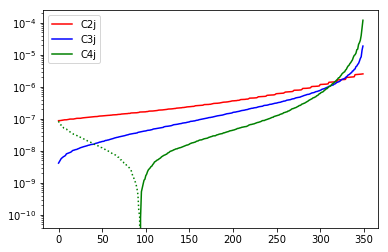

In [47]:
plt.plot(np.linalg.eigvalsh(c2),c='r',label='C2j')
plt.plot(np.linalg.eigvalsh(c3),c='b',label='C3j')
plt.plot(np.linalg.eigvalsh(c4),c='g',label='C4j')
plt.plot(-np.linalg.eigvalsh(c4),c='g',ls=':')
plt.legend()
plt.yscale('log')

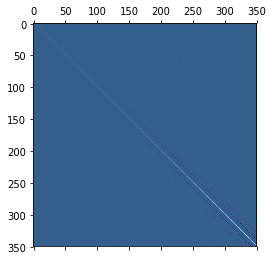

In [51]:
plt.matshow(Psi(1.0))

## N_gal script:

In [20]:
N_gals = np.zeros(20,dtype=int)
for mock_no in range(1,21):
    gal_file = '/mnt/store1/oliverphilcox/DR12_QPM/processed/qpm_galaxy_%d.xyzwj'%mock_no
    with open(gal_file) as infile:
        for l,line in enumerate(infile):
            pass
    N_gals[mock_no-1]=l+1

In [22]:
np.save('/mnt/store1/oliverphilcox/DR12_QPM/N_gal.npy',N_gals)

## Test output

In [54]:
d=np.load('/mnt/store1/oliverphilcox/DR12_QPM/post_processed/mock_1.npz')